In [2]:
!pip install qujax

/srv/conda/envs/notebook/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [13]:
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

In [10]:
## Plot function 
def plot_histogram_and_line(data, final_st):
    fig, ax = plt.subplots()
    
    # Plot histogram for data
    ax.hist(data, bins=50, density=True, alpha=0.5, label="Data")
    
    # Plot line for Final Parameter
    ax.plot(final_st, label="Final Parameter", color='orange')
    
    # Plot line for Averaged over parameters
   # ax.plot(data_avg, label="Averaged over parameters", linestyle='--', color='orange')
    
    # Adjust plot settings
    ax.set_xlim(data.min(), data.max())
    ax.set_ylabel("Probability")
    ax.set_xlabel("Data $\mu$m")
    ax.legend()
    
    return fig

In [4]:
## Plot function 
def plot_histogram_and_line(data, final_st):
    fig, ax = plt.subplots()
    
    # Plot histogram for data
    ax.hist(data, bins=50, density=True, alpha=0.5, label="Data")
     
    temp = param_to_st(final_st)
    final_data_p = jnp.square(jnp.abs(temp.flatten()))
    # Plot line for Final Parameter
    ax.plot(final_data_p, label="Final Parameter", color='orange')
    
    # Plot line for Averaged over parameters
    #ax.plot(data_avg, label="Averaged over parameters", linestyle='--', color='orange')
    
    # Adjust plot settings
    ax.set_xlim(data.min(), data.max())
    ax.set_ylabel("Probability")
    ax.set_xlabel("Data $\mu$m")
    ax.legend()
    
    return fig
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()


def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(s1 - s2) / bandwidth_sq)


def param_to_mmd(param):
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

def compute_av_probs(params, burn_in):
    probs = vmap(lambda p: jnp.square(jnp.abs(param_to_st(p).flatten())))(params[burn_in:])
    return probs.mean(axis=0)

In [14]:
def run_simulation(init_param,n_params, Nsteps, beta, train_keys):
    import time

    bar_length = 30
    
    params = jnp.zeros((Nsteps, n_params))
    params = params.at[0].set(init_param)
    
    cost_vals = jnp.zeros(Nsteps - 1)
    
    start_time = time.time() # Record the start time
    
    for step in range(1, Nsteps):
        cost_val, cost_grad = param_to_mmd_and_grad(params[step - 1] )  +  ### add noise here 
        cost_vals = cost_vals.at[step - 1].set(cost_val)
        
        stepsize = get_stepsize(step)
        
        new_param = (
            params[step - 1]
            - stepsize * cost_grad
            + jnp.sqrt(2 * stepsize / beta)
            * random.normal(train_keys[step - 1], shape=(n_params,))
        )
        params = params.at[step].set(new_param)

        progress = step / Nsteps
        filled_length = int(bar_length * progress)
        bar = '█' * filled_length + '-' * (bar_length - filled_length)
        elapsed_time = time.time() - start_time # Compute the elapsed time
        remaining_time = (elapsed_time / step) * (Nsteps - step) # Estimate the remaining time
        print(f'\rProgress: |{bar}| {progress:.2%} | Iteration: {step}/{Nsteps} | Cost: {cost_val:.6f} | Elapsed Time: {elapsed_time:.2f}s | Estimated Remaining Time: {remaining_time:.2f}s', end='')
    
    print() # Move to the next line after the progress bar
    
    total_run_time = time.time() - start_time # Compute the total run time
    
    return params, cost_vals, total_run_time

Progress: |█████████████████████████████-| 99.80% | Iteration: 499/500 | Cost: 0.001459 | Elapsed Time: 18.97s | Estimated Remaining Time: 0.04ss


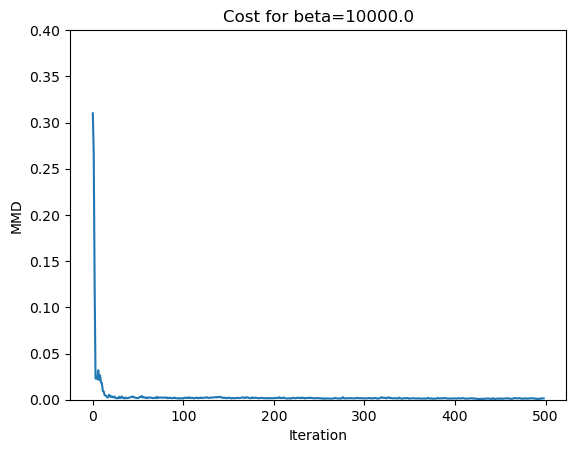

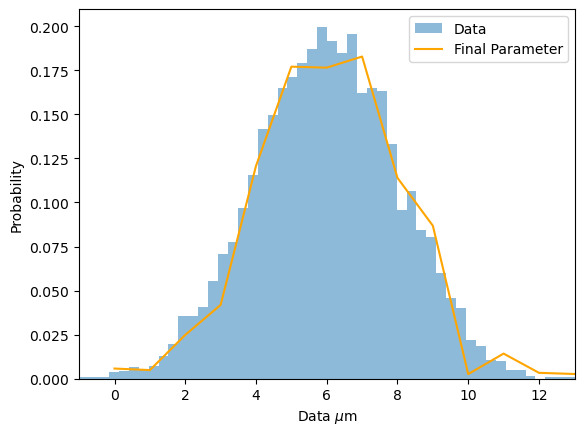

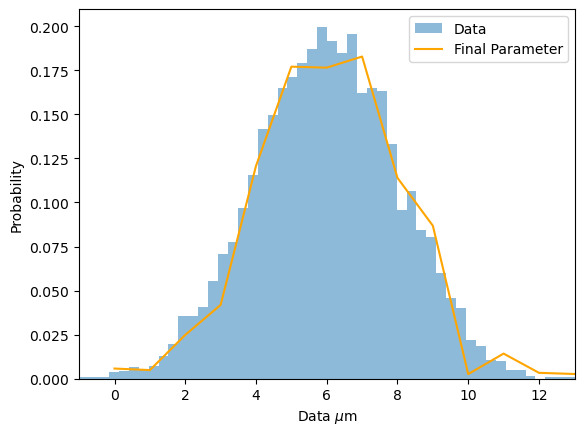

In [24]:
#### test 
# number_of_data_points = 5000
# n_steps = 500
# n_qubits = 8
# circuit_depth = 3
# init_rad = 0.001 / jnp.pi
# beta = 1e4
# get_stepsize = lambda step: (step + 10) ** (-1 / 3)
# random_key = random.PRNGKey(0)

# init_key, train_key = random.split(random_key)
# train_keys = random.split(train_key, n_steps - 1)

# gaussian = (6,2)   # For the gen data 
# # Generate random numbers following a Gaussian distribution
# key = random.PRNGKey(0)  # Initialize a random key
# mu = gaussian[0]                   # Mean of the Gaussian distribution
# sigma = gaussian[1]                # Standard deviation of the Gaussian distribution

# # Generate Gaussian distribution
# data = random.normal(key, shape=(number_of_data_points,), dtype=jnp.float32) * sigma + mu


# ## These take awhile for large data sets
# # computes pairwise 
# dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
# # get bandwidth
# bandwidth_sq = jnp.median(dist_mat) / 2


# gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)


# param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
   

# data_probs = jnp.ones(len(data)) / len(data)

# param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
    
# init_param = random.uniform(
#     init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
#     )

# params, cost_vals, total_run_time = run_simulation(init_param,n_params, n_steps, beta, train_keys)

# plt.plot(cost_vals)
# plt.title(f'Cost for beta={beta}')
# plt.xlabel("Iteration")
# plt.ylabel("MMD")
# plt.ylim(0, 0.4)
# plt.show() 


# plot_histogram_and_line(data, params[-1])

In [4]:
#### gen data for all test
### only run once
# gaussian = (6, 2)  # For the gen data
# number_of_data_points = 5000

# # Generate random numbers following a Gaussian distribution
# key = random.PRNGKey(0)  # Initialize a random key
# mu = gaussian[0]  # Mean of the Gaussian distribution
# sigma = gaussian[1]  # Standard deviation of the Gaussian distribution

# # Generate Gaussian distribution
# data = random.normal(key, shape=(number_of_data_points,), dtype=jnp.float32) * sigma + mu
# data_save_str=f'data_{number_of_data_points}_{mu}_{sigma}'

# with open(f'og_func/{data_save_str}.pkl', 'wb') as file:
#     pickle.dump(data, file)

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.333961 | Elapsed Time: 246.96s | Estimated Remaining Time: 0.02sss


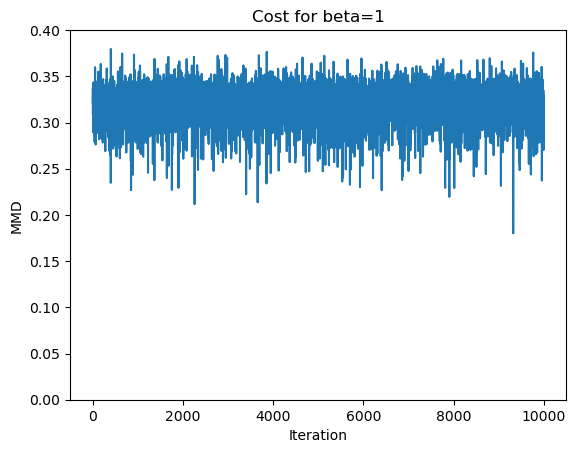

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.039965 | Elapsed Time: 246.61s | Estimated Remaining Time: 0.02sss


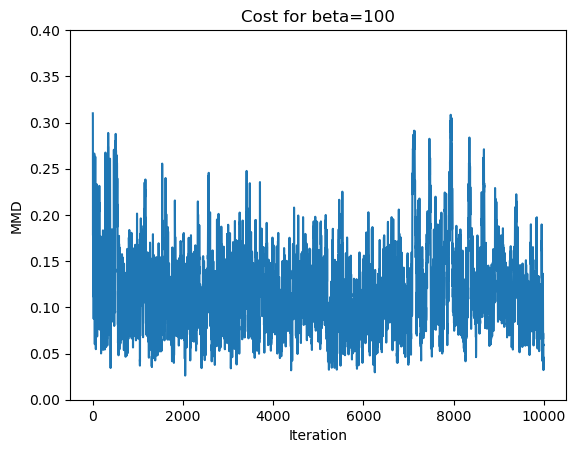

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.010895 | Elapsed Time: 248.08s | Estimated Remaining Time: 0.02sss


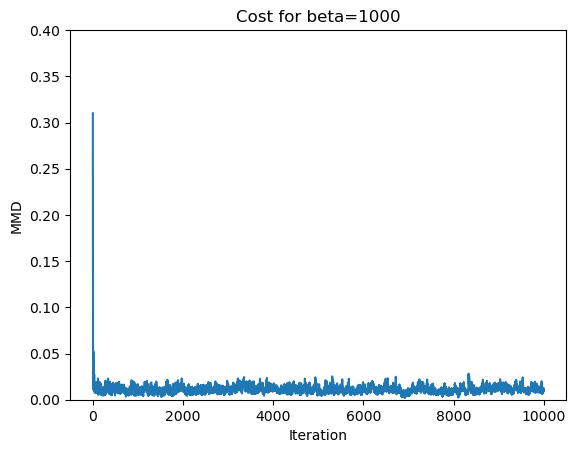

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.000705 | Elapsed Time: 247.72s | Estimated Remaining Time: 0.02sss


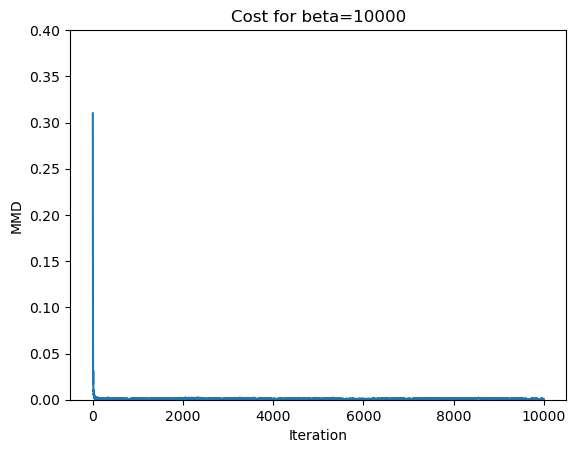

In [6]:
### test for betas 
date_name ='data_5000_6_2'
with open(f'og_func/{date_name}.pkl', 'rb') as file:
    data = pickle.load(file)
betas = [1, 100, 1000, 10000]  # Set the range of betas for the sim

number_of_data_points = 5000
n_steps = 10000
n_qubits = 8
circuit_depth = 3
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)

## These take awhile for large data sets
# computes pairwise
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)

# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

results_beta = {}

for beta in betas:
    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    data_probs = jnp.ones(len(data)) / len(data)
    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))

    init_param = random.uniform(
        init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )

    train_keys = random.split(train_key, n_steps - 1)
    params, cost_vals, total_run_time = run_simulation(init_param, n_params, n_steps, beta, train_keys)

    plt.plot(cost_vals)
    plt.title(f'Cost for beta={beta}')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show()

    final_params = params[-1]
    final_st = param_to_st(final_params)
    
    results_beta[str(beta)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals, total_run_time, params)
# Save results_beta to a file
with open('og_func/results_beta.pkl', 'wb') as file:
    pickle.dump(results_beta, file)

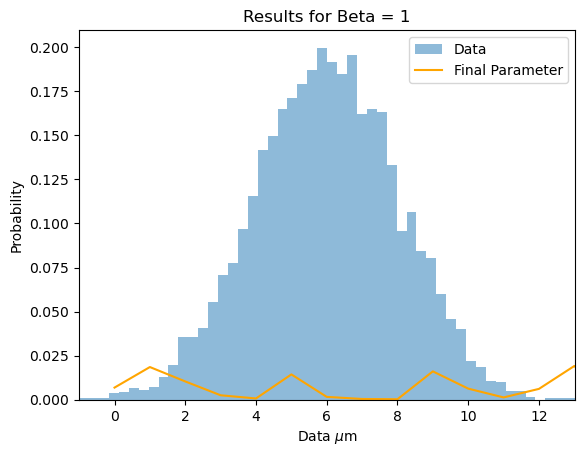

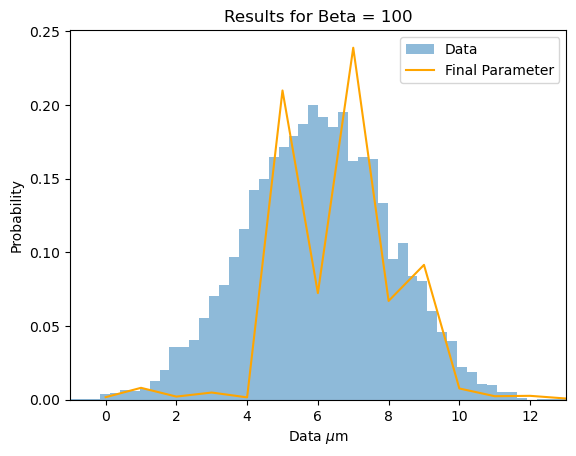

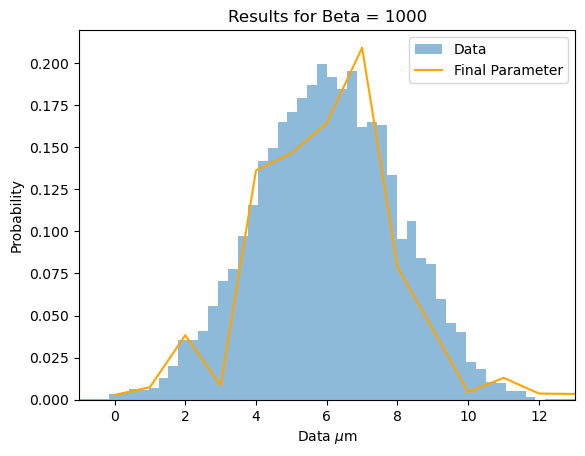

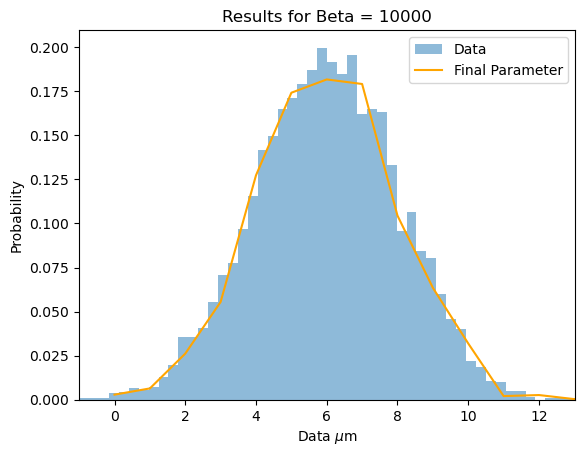

In [11]:
# Iterate over the results_beta dictionary and plot each set of results
for beta, (final_st, cost,time,_ ) in results_beta.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for Beta = {beta}")
    plt.show()

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.006999 | Elapsed Time: 238.60s | Estimated Remaining Time: 0.02sss


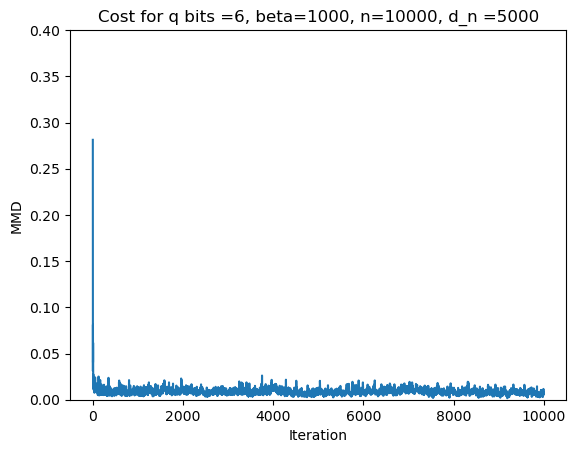

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.010895 | Elapsed Time: 247.18s | Estimated Remaining Time: 0.02sss


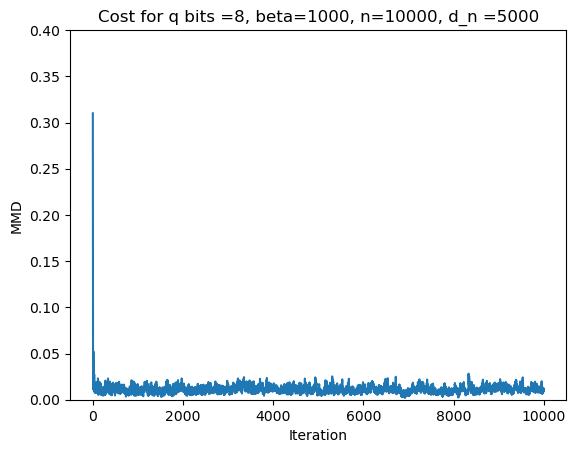

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.010418 | Elapsed Time: 310.02s | Estimated Remaining Time: 0.03sss


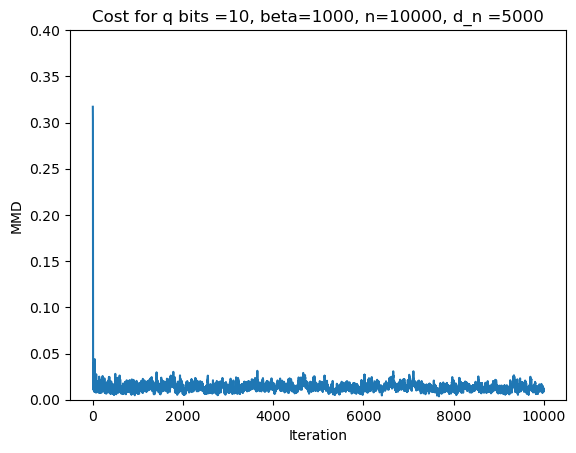

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.023007 | Elapsed Time: 896.55s | Estimated Remaining Time: 0.09sss


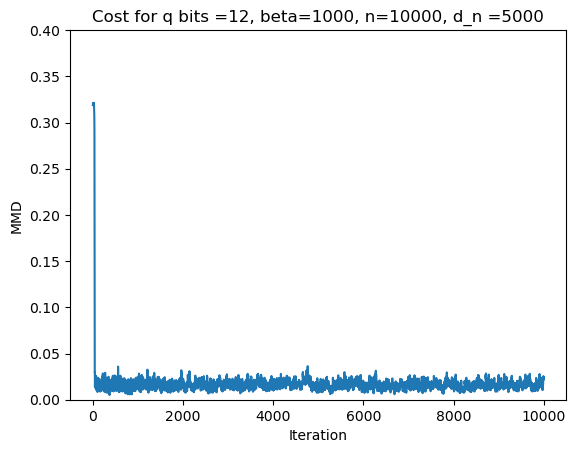

In [15]:
# Load data
date_name = 'data_5000_6_2'
with open(f'og_func/{date_name}.pkl', 'rb') as file:
    data = pickle.load(file)

beta = 1000  # Set the beta value for the simulation

number_of_data_points = 5000
n_qubits_list = [6, 8, 10, 12]  # List of number of qubits to test
circuit_depth = 3
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)

## These take awhile for large data sets
# computes pairwise
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)

# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory
results_qubits = {}

for n_qubits in n_qubits_list:
    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    data_probs = jnp.ones(len(data)) / len(data)
    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))

    init_param = random.uniform(
        init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )

    train_keys = random.split(train_key, n_steps - 1)

    params, cost_vals, total_run_time = run_simulation(init_param, n_params, n_steps, beta, train_keys)

    plt.plot(cost_vals)
    plt.title(f'Cost for q bits ={n_qubits}, beta={beta}, n={n_steps}, d_n ={number_of_data_points}')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show()

    final_params = params[-1]
    final_st = param_to_st(final_params)

    results_qubits[str(n_qubits)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals, total_run_time, params)

# Save results_qubits to a file
with open('og_func/results_qubits.pkl', 'wb') as file:
    pickle.dump(results_qubits, file)

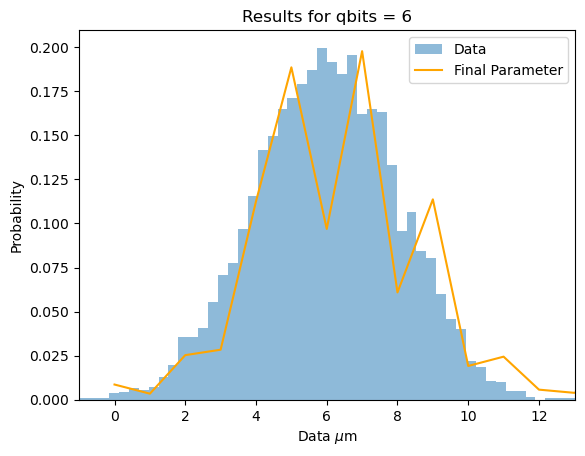

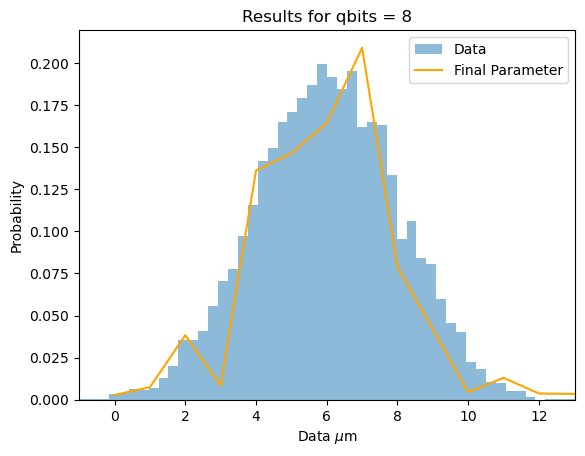

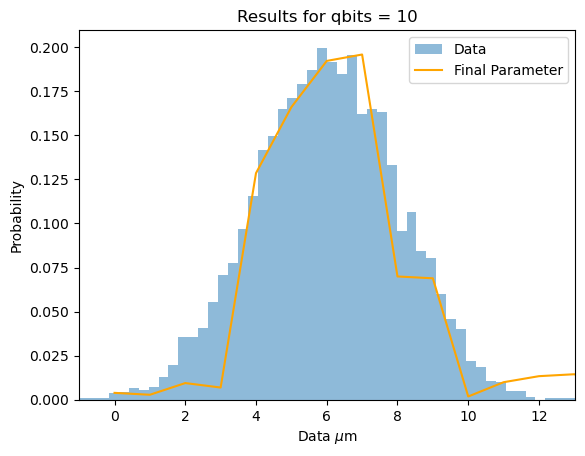

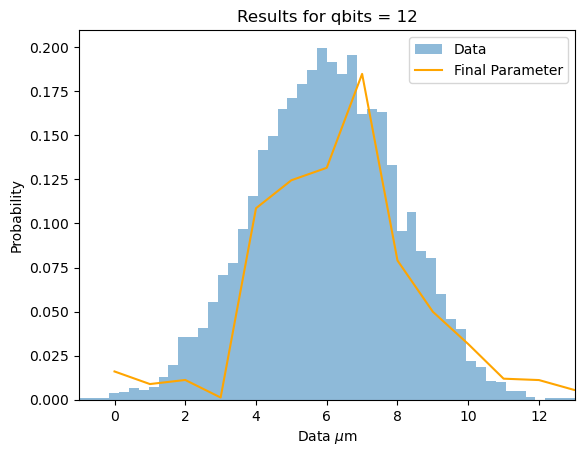

In [17]:
# Iterate over the results_beta dictionary and plot each set of results
for qbits, (final_st, cost,time,_ ) in results_qubits.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for qbits = {qbits}")
    plt.show()

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.008705 | Elapsed Time: 244.46s | Estimated Remaining Time: 0.02sss


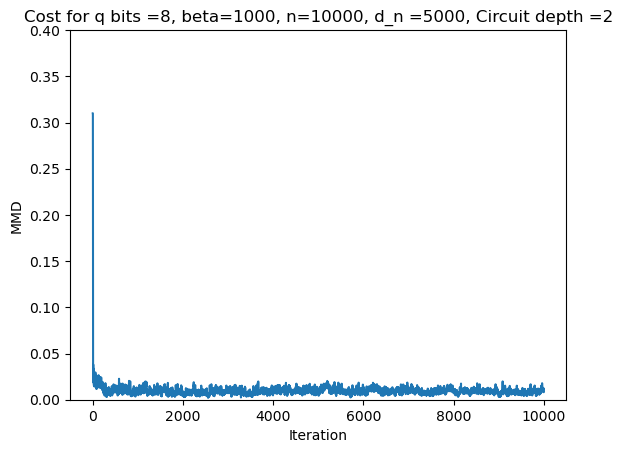

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.010895 | Elapsed Time: 247.40s | Estimated Remaining Time: 0.02sss


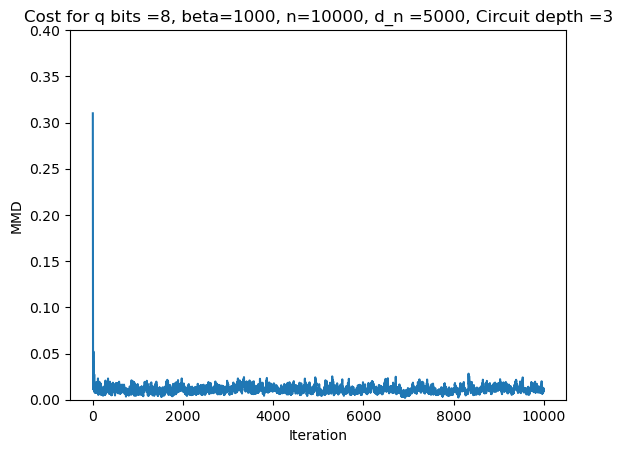

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.007350 | Elapsed Time: 251.42s | Estimated Remaining Time: 0.03sss


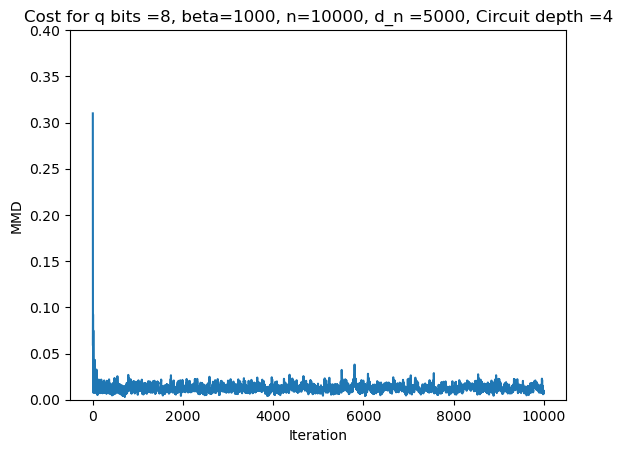

Progress: |█████████████████████████████-| 99.99% | Iteration: 9999/10000 | Cost: 0.013701 | Elapsed Time: 254.95s | Estimated Remaining Time: 0.03sss


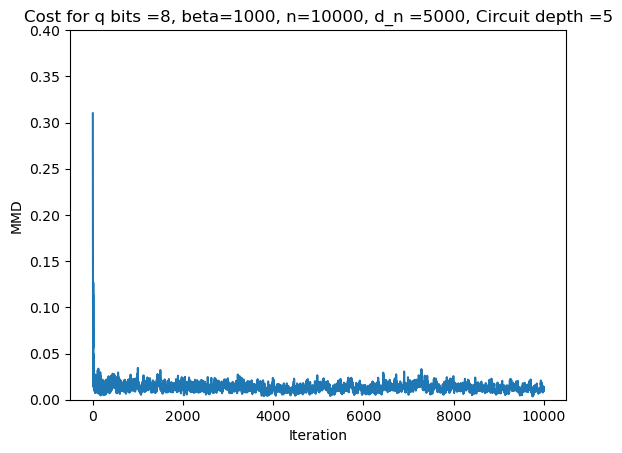

In [18]:
# Load data
date_name = 'data_5000_6_2'
with open(f'og_func/{date_name}.pkl', 'rb') as file:
    data = pickle.load(file)

beta = 1000  # Set the beta value for the simulation
number_of_data_points = 5000
n_qubits = 8  # Number of qubits
circuit_depth_list = [2, 3, 4, 5]  # List of circuit depths to test
init_rad = 0.001 / jnp.pi
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 10000
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)

## These take awhile for large data sets
# computes pairwise
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)

# get bandwidth
bandwidth_sq = jnp.median(dist_mat) / 2

# allocate memory
results_circuit_depth = {}

for circuit_depth in circuit_depth_list:
    gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
    param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
    data_probs = jnp.ones(len(data)) / len(data)
    param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))

    init_param = random.uniform(
        init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
    )

    train_keys = random.split(train_key, n_steps - 1)

    params, cost_vals, total_run_time = run_simulation(init_param, n_params, n_steps, beta, train_keys)

    plt.plot(cost_vals)
    plt.title(f'Cost for q bits ={n_qubits}, beta={beta}, n={n_steps}, d_n ={number_of_data_points}, Circuit depth ={circuit_depth}')
    plt.xlabel("Iteration")
    plt.ylabel("MMD")
    plt.ylim(0, 0.4)
    plt.show()

    final_params = params[-1]
    final_st = param_to_st(final_params)

    results_circuit_depth[str(circuit_depth)] = (jnp.square(jnp.abs(final_st.flatten())), cost_vals, total_run_time, params)

# Save results_circuit_depth to a file
with open('og_func/results_circuit_depth.pkl', 'wb') as file:
    pickle.dump(results_circuit_depth, file)

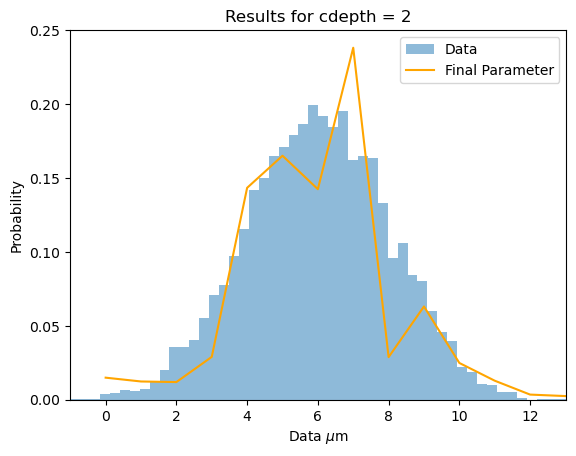

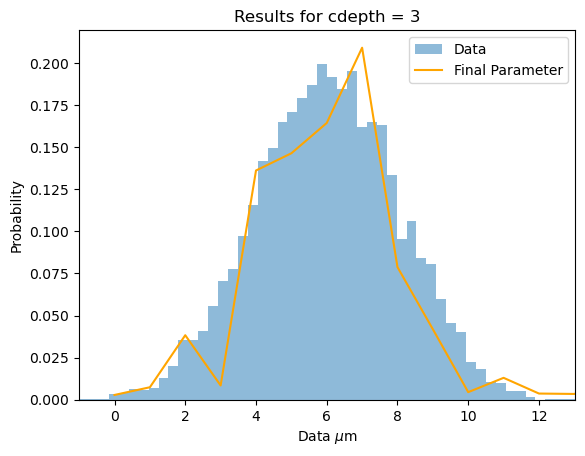

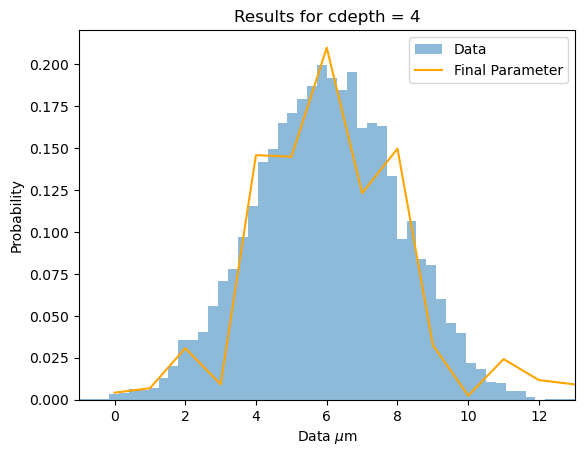

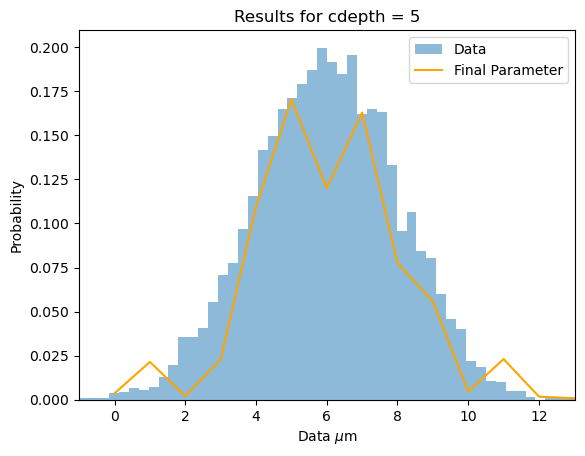

In [19]:
# Iterate over the results_beta dictionary and plot each set of results
for cdepth, (final_st, cost,time,_ ) in results_circuit_depth.items():
    fig = plot_histogram_and_line(data, final_st)
    plt.title(f"Results for cdepth = {cdepth}")
    plt.show()